In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

In [2]:
#Install Additional Libraries
!pip install keras_cv

zsh:1: /usr/local/bin/pip: bad interpreter: /System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: no such file or directory
  Obtaining dependency information for keras_cv from https://files.pythonhosted.org/packages/be/4c/a45de94dcaa533bdf1dce1643321d57452c79e7b581c9d573facf10c7118/keras_cv-0.6.4-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow-datasets from https://files.pythonhosted.org/packages/a1/73/7a9ed7935f6833d73b32f1e2a1210082f5ccb95445440b4e2b0f66ab7792/tensorflow_datasets-4.9.3-py3-none-any.whl.metadata
  Obtaining dependency information for keras-core from https://files.pythonhosted.org/packages/95/f7/b8dcff937ea64f822f0d3fe8c6010793406b82d14467cd0e9eecea458a40/keras_core-0.1.7-py3-none-any.whl.metadata
  Obtaining dependency information for rich from https://files.pythonhosted.org/packages/be/2a/4e62ff633612f746f88618852a626bbe24226eba5e7ac90e91dcfd6a414e/rich-13.6.0-py3-none-any.whl.metadata
     ━

In [ ]:
#Import Libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import random
from sklearn.model_selection import train_test_split

mc_image_dir = '/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Montgomery Images/'
shenzen_image_dir = '/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Images/'
mc_mask_dir ='/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Montgomery Masks/'
shenzen_mask_dir = '/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/'

mc_image_filenames = os.listdir(mc_image_dir)
mc_mask_filenames = os.listdir(mc_mask_dir)
shenzen_image_filenames = os.listdir(shenzen_image_dir)
shenzen_mask_filenames = os.listdir(shenzen_mask_dir)

In [ ]:
def sorted_paths(image_filenames, mask_filenames, image_dir, mask_dir):
  image_paths = []
  mask_paths = []
  for image_name in image_filenames:
      for mask_name in mask_filenames:
          if image_name[7:12] == mask_name[7:12]:
              image_paths.append(os.path.join(image_dir, image_name))
              mask_paths.append(os.path.join(mask_dir, mask_name))
  assert len(image_paths) == len(mask_paths)
  return image_paths, mask_paths

def load_data(image_path, mask_path, size=(128,128)):
  #Load Image
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = tf.image.resize(image, size)
  image = tf.cast(image, tf.float32) / 255.0

  #Load Mask
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, 1)
  mask = tf.image.resize(mask, size)
  mask = tf.cast(mask, tf.float32) / 255.0
  return image, mask

def data_visualiser(image):
  image_np = image.numpy()
  print(f"Array Shape is {np.shape(image_np)}")
  plt.imshow(image_np)
  plt.axis('off')
  plt.show()

def train_test_split(sorted_image_paths, sorted_mask_paths, split_ratio=0.2):
  assert len(sorted_image_paths) == len(sorted_mask_paths)
  sorted_paths = list(zip(sorted_image_paths, sorted_mask_paths))
  split_threshold = int((1 - split_ratio) * len(sorted_paths))
  random.shuffle(sorted_paths)
  train_data_paths = sorted_paths[:split_threshold]
  test_data_paths = sorted_paths[split_threshold+1:]
  train_image_paths, train_mask_paths = zip(*train_data_paths)
  test_image_paths, test_mask_paths = zip(*test_data_paths)
  #Convert to lists
  train_image_paths = list(train_image_paths)
  train_mask_paths = list(train_mask_paths)
  test_image_paths = list(test_image_paths)
  test_mask_paths = list(test_mask_paths)
  return train_image_paths, train_mask_paths, test_image_paths, test_mask_paths

In [ ]:
mc_image_paths, mc_mask_paths = sorted_paths(mc_image_filenames, mc_mask_filenames, mc_image_dir, mc_mask_dir)
shenzen_image_paths, shenzen_mask_paths = sorted_paths(shenzen_image_filenames, shenzen_mask_filenames, shenzen_image_dir, shenzen_mask_dir)
sorted_image_paths = mc_image_paths + shenzen_image_paths
sorted_mask_paths = mc_mask_paths + shenzen_mask_paths
train_image_paths, train_mask_paths, test_image_paths, test_mask_paths = train_test_split(sorted_image_paths, sorted_mask_paths)

train_image_paths_tensor = tf.data.Dataset.from_tensor_slices(train_image_paths)
train_mask_paths_tensor = tf.data.Dataset.from_tensor_slices(train_mask_paths)
train_dataset = tf.data.Dataset.zip(train_image_paths_tensor, train_mask_paths_tensor)
train_dataset = train_dataset.map(load_data)
print(len(train_dataset))

test_image_paths_tensor = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_mask_paths_tensor = tf.data.Dataset.from_tensor_slices(test_mask_paths)
test_dataset = tf.data.Dataset.zip(test_image_paths_tensor, test_mask_paths_tensor)
test_dataset = test_dataset.map(load_data)
print(len(test_dataset))

563
140


/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Montgomery Images/MCUCXR_0331_1.png
Array Shape is (128, 128, 1)


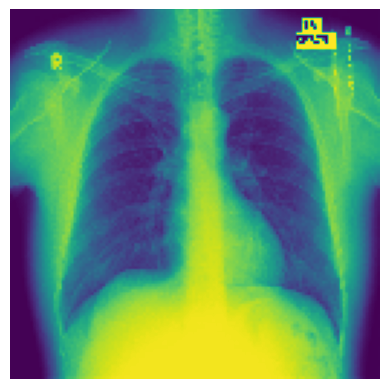

/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Montgomery Masks/MCUCXR_0331_1.png
Array Shape is (128, 128, 1)


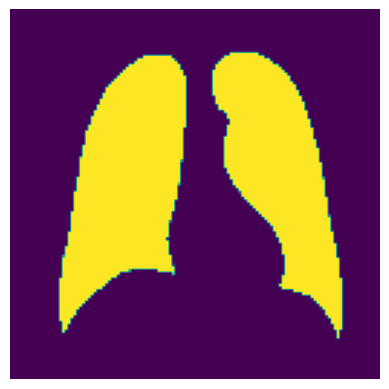

In [ ]:
#Visualise Training Data
index = random.randint(0, len(train_image_paths))
sample_image_path = train_image_paths[index]
sample_mask_path = train_mask_paths[index]
sample_image, sample_mask = load_data(sample_image_path, sample_mask_path)
print(sample_image_path)
data_visualiser(sample_image)
print(sample_mask_path)
data_visualiser(sample_mask)

In [ ]:
#Define Model
import keras
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, MaxPooling2D, multiply
from keras_cv.layers import DropBlock2D
from keras.models import Model

def mcd_unet(input_size=(128,128,1),filters_init=32, activation_fn='relu', kernel_init='he_normal', drop_rate=0.2, block_size=7):

  #Define Double Convolution Layer
  def conv_layer(filters, inputs, use_dropblock=False, use_spatial_attention=False):
    x = Conv2D(filters, (3,3), activation=None, padding='same', kernel_initializer=kernel_init)(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation_fn)(x)
    if use_dropblock:
      x = DropBlock2D(drop_rate, block_size)(x)
    if use_spatial_attention:
      x = spatial_attention(x)
    x = Conv2D(filters, (3,3), activation=None, padding='same', kernel_initializer=kernel_init)(x)
    x = BatchNormalization()(x)
    x = Activation(activation_fn)(x)
    if use_dropblock:
      x = DropBlock2D(drop_rate, block_size)(x)
    return x

  def spatial_attention(input_feature):
    """TensorFlow 2 Implementation of Convolutional Block Attention Module - https://arxiv.org/pdf/1807.06521.pdf """
    kernel_size = 7
    avg_pool = tf.reduce_mean(input_feature, axis=[3], keepdims=True)
    assert avg_pool.shape[-1] == 1
    max_pool = tf.reduce_max(input_feature, axis=[3], keepdims=True)
    assert avg_pool.shape[-1] == 1
    concat = concatenate([avg_pool, max_pool], axis=3)
    assert concat.shape[-1] == 2
    conv_layer = Conv2D(filters=1,
                        kernel_size = (kernel_size, kernel_size),
                        activation=None,
                        padding='same',
                        kernel_initializer = kernel_init,
                        use_bias=False)(concat)
    assert conv_layer.shape[-1] == 1
    sigmoid_output = tf.keras.activations.sigmoid(conv_layer)
    return multiply([input_feature, sigmoid_output])


  inputs = Input(input_size)
  enc_layer1 = conv_layer(filters_init, inputs)
  pool1 = MaxPooling2D((2,2))(enc_layer1)

  enc_layer2 = conv_layer(2*filters_init, pool1)
  pool2 = MaxPooling2D((2,2))(enc_layer2)

  enc_layer3 = conv_layer(4*filters_init, pool2)
  pool3 = MaxPooling2D((2,2))(enc_layer3)

  enc_layer4 = conv_layer(8*filters_init, pool3)
  pool4 = MaxPooling2D((2,2))(enc_layer4)

  enc_layer5 = conv_layer(16*filters_init, pool4, use_spatial_attention=True)

  dec_layer4 = concatenate([Conv2DTranspose(8*filters_init, (2, 2), strides=(2, 2), padding='same')(enc_layer5), enc_layer4], axis=3)
  dec_layer4 = conv_layer(8*filters_init, dec_layer4, use_dropblock=True)

  dec_layer3 = concatenate([Conv2DTranspose(4*filters_init, (2, 2), strides=(2, 2), padding='same')(dec_layer4), enc_layer3], axis=3)
  dec_layer3 = conv_layer(4*filters_init, dec_layer3, use_dropblock=True)

  dec_layer2 = concatenate([Conv2DTranspose(2*filters_init, (2, 2), strides=(2, 2), padding='same')(dec_layer3), enc_layer2], axis=3)
  dec_layer2 = conv_layer(2*filters_init, dec_layer2, use_dropblock=True)

  dec_layer1 = concatenate([Conv2DTranspose(filters_init, (2, 2), strides=(2, 2), padding='same')(dec_layer2), enc_layer1], axis=3)
  dec_layer1 = conv_layer(filters_init, dec_layer1, use_dropblock=True)

  out_layer = Conv2D(1, (1,1), activation='sigmoid')(dec_layer1)

  return Model(inputs=[inputs], outputs=[out_layer])





Using TensorFlow backend


In [ ]:
from keras.optimizers import RMSprop
tf.config.run_functions_eagerly(True)
model = mcd_unet()
model.compile(optimizer= RMSprop(lr=0.001), loss='binary_crossentropy',metrics=['binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 32)         0         ['batch_normalization[0][0

In [ ]:
#Define Custom Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'binary_accuracy',
                              factor = 0.5,
                              patience = 8,
                              min_lr = 1e-5,
                              verbose = 1)

In [ ]:
#Batch Data
batch_size = 32
train_data = train_dataset.batch(batch_size)
train_hist = model.fit(train_data,epochs=50, callbacks=[reduce_lr])


Epoch 1/50
18/18 [==============================] - 97s 5s/step - loss: 0.4673 - binary_accuracy: 0.8161 - lr: 0.0010
Epoch 2/50
18/18 [==============================] - 19s 1s/step - loss: 0.2420 - binary_accuracy: 0.9448 - lr: 0.0010
Epoch 3/50
18/18 [==============================] - 19s 999ms/step - loss: 0.1801 - binary_accuracy: 0.9646 - lr: 0.0010
Epoch 4/50
18/18 [==============================] - 17s 934ms/step - loss: 0.1517 - binary_accuracy: 0.9692 - lr: 0.0010
Epoch 5/50
18/18 [==============================] - 18s 951ms/step - loss: 0.1295 - binary_accuracy: 0.9727 - lr: 0.0010
Epoch 6/50
18/18 [==============================] - 18s 1s/step - loss: 0.1164 - binary_accuracy: 0.9734 - lr: 0.0010
Epoch 7/50
18/18 [==============================] - 18s 945ms/step - loss: 0.1026 - binary_accuracy: 0.9751 - lr: 0.0010
Epoch 8/50
18/18 [==============================] - 18s 961ms/step - loss: 0.0922 - binary_accuracy: 0.9763 - lr: 0.0010
Epoch 9/50
18/18 [=======================

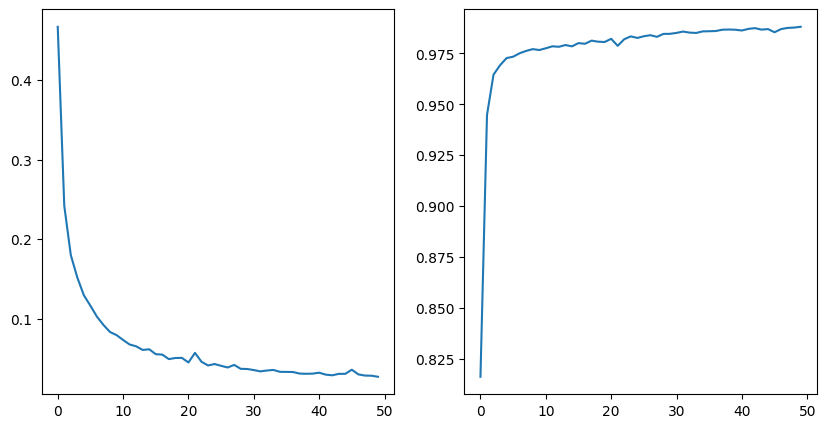

In [ ]:
#Training Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(train_hist.history['loss'], '-', label = 'Loss')
ax2.plot(train_hist.history['binary_accuracy'], label='Binary Accuracy')


In [ ]:
#Batch test data
test_data_batched = test_dataset.batch(batch_size)
predictions = model.predict(test_data_batched)

5/5 [==============================] - 24s 4s/step


/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/CHNCXR_0090_0_mask.png


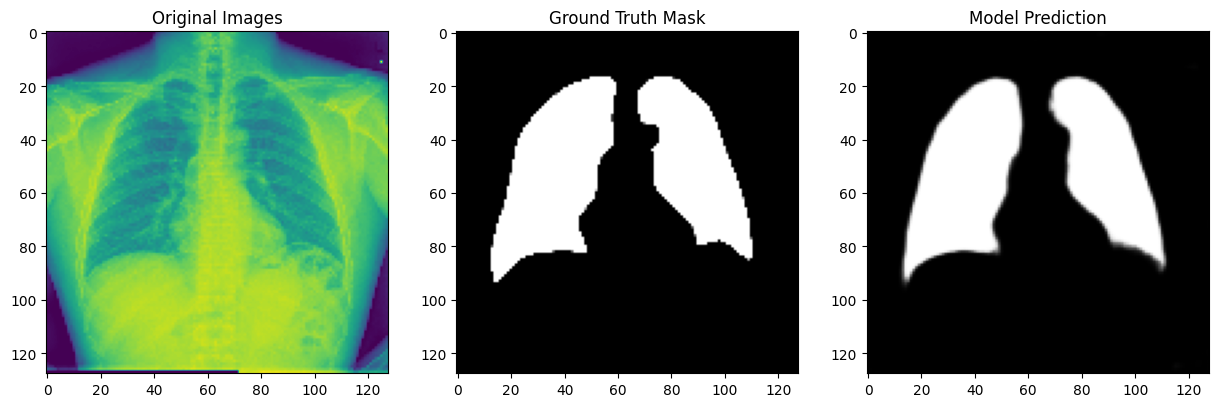

/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/CHNCXR_0640_1_mask.png


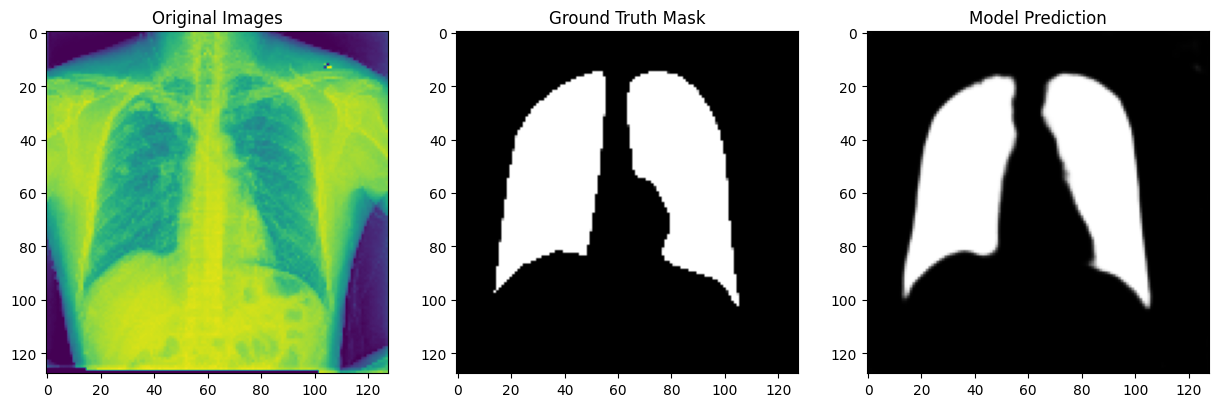

/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/CHNCXR_0224_0_mask.png


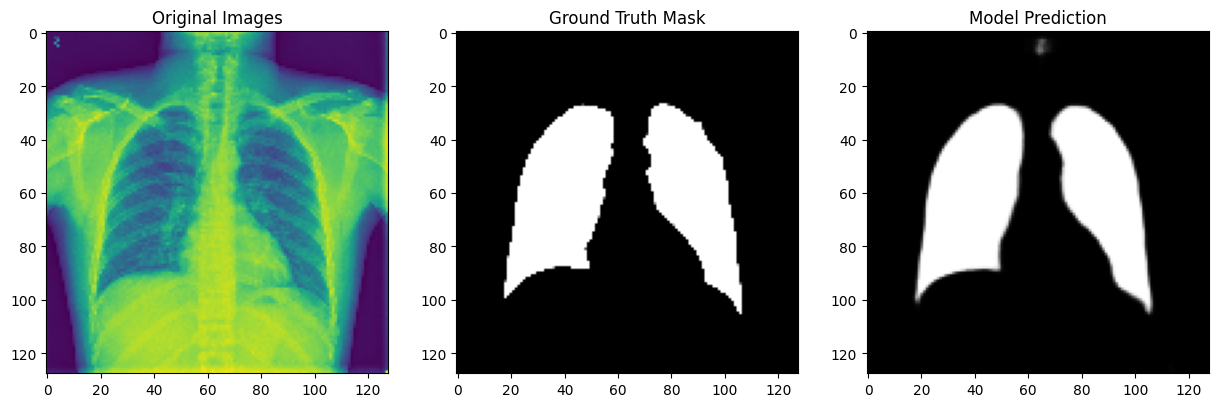

/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/CHNCXR_0289_0_mask.png


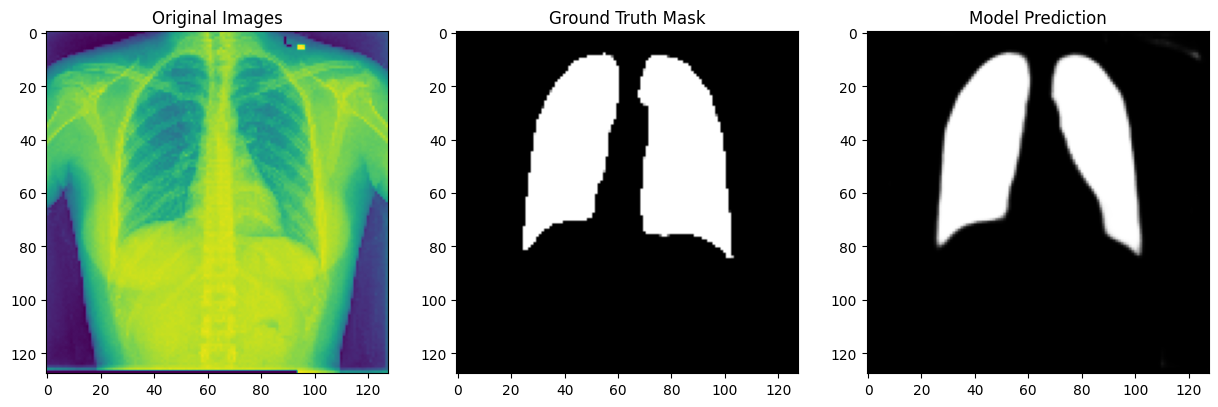

/content/drive/MyDrive/CV_datasets/NLM Chest X-Rays/Shenzen Masks/CHNCXR_0172_0_mask.png


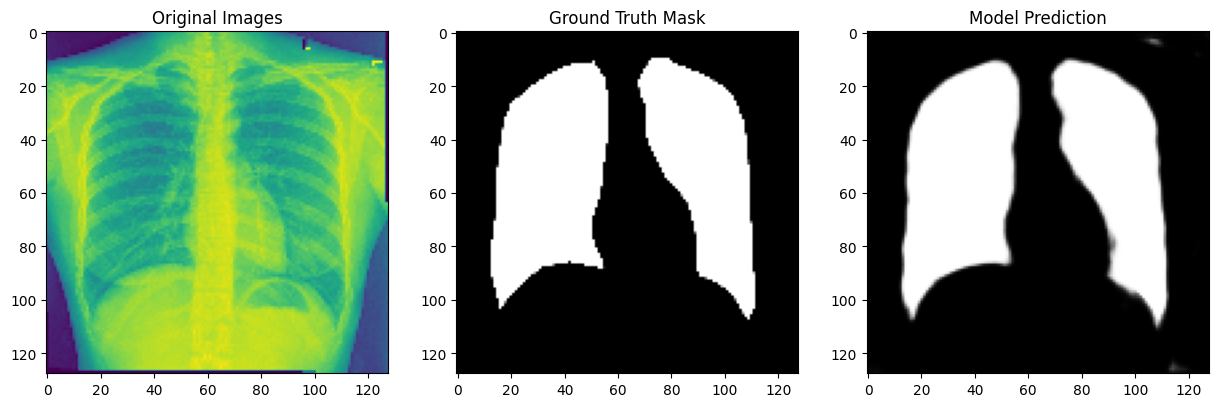

In [ ]:
#Visualise Results
for i in range(0,5):
  test_image_element, test_mask_element = load_data(test_image_paths[i], test_mask_paths[i])

  #Convert to NumPy Arrays
  test_image = test_image_element.numpy()
  test_mask = test_mask_element.numpy()
  prediction = predictions[i]

  plt.figure(figsize=(15, 5))

  # Original Image
  plt.subplot(1, 3, 1)
  plt.imshow(test_image)
  plt.title(f"Original Images")
  print(f"{test_mask_paths[i]}")

  # Ground Truth Mask
  plt.subplot(1, 3, 2)
  plt.imshow(test_mask, cmap='gray')
  plt.title('Ground Truth Mask')

  # Model Prediction
  plt.subplot(1, 3, 3)
  plt.imshow(prediction, cmap='gray')
  plt.title('Model Prediction')

  plt.show()



In [ ]:
#Uncertanity Estimation
def Entropy(X, axis=-1):
  return -1* np.sum(X * np.log(X+1E-12), axis=axis)

def calc_uncertainity(predictions):
  mean = np.mean(predictions, axis=0)
  std_dev = np.std(predictions, axis=0)
  entropy=Entropy(np.mean(predictions, axis=0),axis=-1)
  entropy_exp = np.mean(Entropy(predictions, axis=1))
  mutual_info = entropy - entropy_exp
  std_dev = np.std(predictions, 0)
  aleatoric = np.mean(predictions*(1-predictions), axis=0)
  epistemic = np.mean(predictions**2, axis=0) - np.mean(predictions, axis=0)**2
  overall= aleatoric + epistemic
  return mean, std_dev, entropy, mutual_info, std_dev, aleatoric, epistemic , overall

def inference(model,image,N=20,threshold=0.05):
  image_batched = np.expand_dims(image, axis=0)
  #Perform N stochastic forward passes
  predicted_masks = []
  for i in range(0,N):
    prediction = model.predict(image_batched)
    predicted_masks.append(prediction)
  predicted_masks = np.array(predicted_masks)
  mean, std_dev, entropy, mutual_info, std_dev, aleatoric, epistemic , overall = calc_uncertainity(predicted_masks)
  uncert_prediction = np.where(overall > threshold*np.max(overall), 1, 0)
  return np.squeeze(mean), np.squeeze(std_dev), np.squeeze(uncert_prediction), np.squeeze(aleatoric), np.squeeze(epistemic)







In [ ]:
#Inference
import numpy as np
sample_image_index = 0 # Replace with the desired index

# Iterate through the dataset to access the element at the specified index
for index, pair in enumerate(test_dataset):
    if index == sample_image_index:
        test_image, test_mask = pair
        break

# Add a batch dimension to the image
np.shape(test_image)


TensorShape([128, 128, 1])

In [ ]:
mean, std_dev, overall, aleatoric, epistemic = inference(model, test_image)

1/1 [==============================] - 0s 62ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 67ms/step


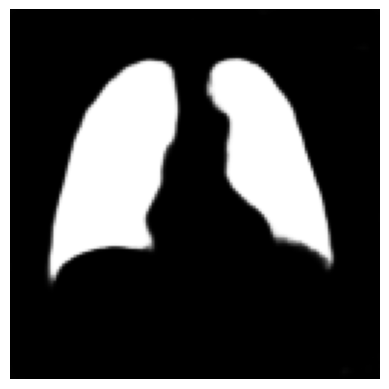

In [ ]:
plt.imshow(mean, cmap='gray')
plt.axis('off')
plt.show()

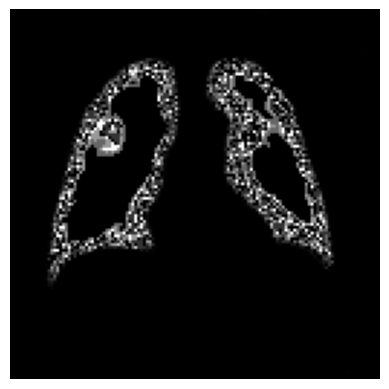

In [ ]:
plt.imshow(std_dev, cmap='gray')
plt.axis('off')
plt.show()

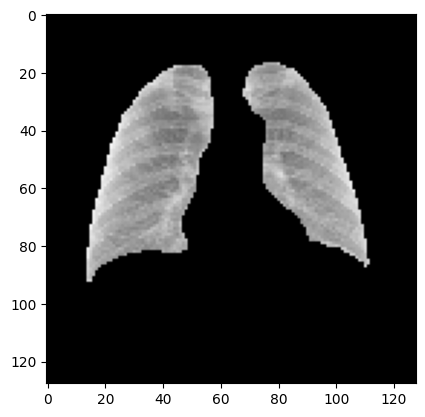

In [ ]:
import cv2
def overlay_data(image_array, mask_array, threshold_value=0.5):
  binary_mask = (mean >= threshold_value).astype(np.uint8)
  mask = binary_mask > 0
  overlay = np.zeros_like(image_array)
  overlay[mask] = image_array[mask]
  return overlay

image = test_image.numpy()
ground_truth_mask = test_mask.numpy()
overlay = overlay_data(image, mean)
plt.imshow(overlay, cmap='gray')

1/1 [==============================] - 0s 62ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 62ms/step
Uncertanity (Aleatoric + Epistemic): 0.05535888671875


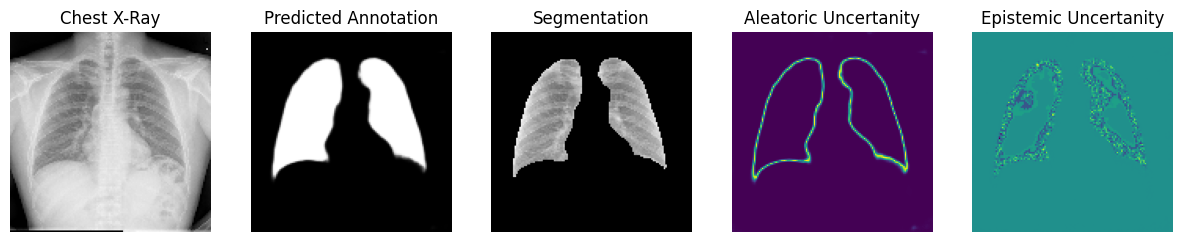

(128, 128) (128, 128)
F1 Score: 0.9645214521452146
1/1 [==============================] - 0s 60ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 62ms/step
Uncertanity (Aleatoric + Epistemic): 0.05535888671875


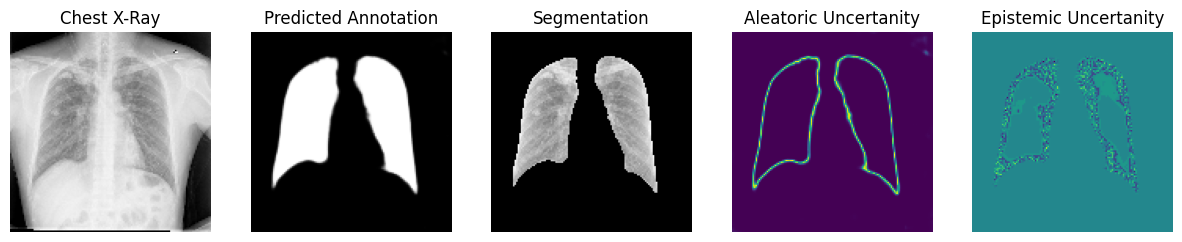

(128, 128) (128, 128)
F1 Score: 0.9365794278758368
1/1 [==============================] - 0s 61ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 66ms/step
Uncertanity (Aleatoric + Epistemic): 0.05535888671875


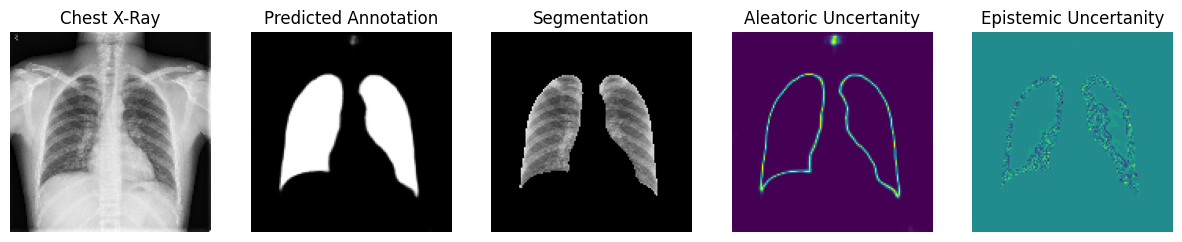

(128, 128) (128, 128)
F1 Score: 0.9724468403713687
1/1 [==============================] - 0s 63ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 61ms/step
Uncertanity (Aleatoric + Epistemic): 0.05535888671875


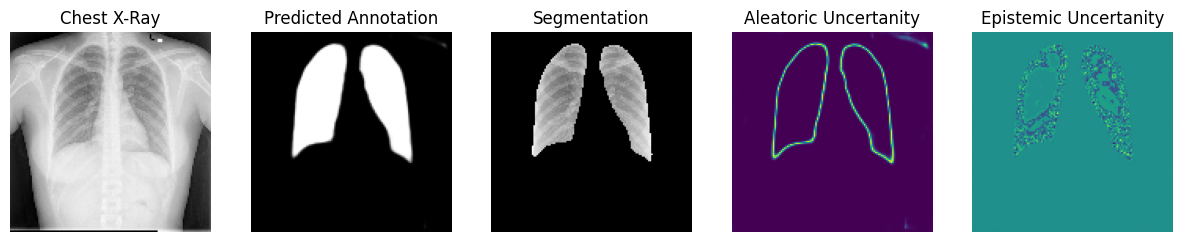

(128, 128) (128, 128)
F1 Score: 0.9076597033000302
1/1 [==============================] - 0s 64ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 62ms/step
Uncertanity (Aleatoric + Epistemic): 0.05535888671875


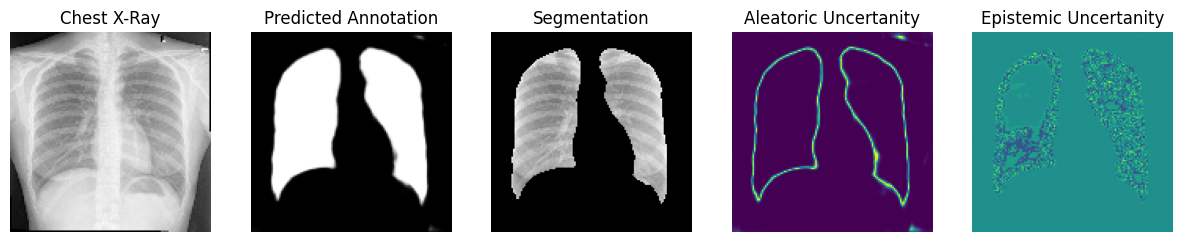

(128, 128) (128, 128)
F1 Score: 0.9711276215555347


In [ ]:
from sklearn.metrics import f1_score
#Visualise Results
for i in range(0,5):
  test_image_element, test_mask_element = load_data(test_image_paths[i], test_mask_paths[i])

  #Convert to NumPy Arrays
  image = test_image_element.numpy()
  ground_truth_mask = test_mask_element.numpy()

  mean, _, prediction, aleatoric, epistemic = inference(model, image)
  print(f"File Path: {test_image_paths[i]}")

  overlay = overlay_data(image, mean)

  plt.figure(figsize=(15, 5))

  #CXR
  plt.subplot(1, 5, 1)
  plt.axis('off')
  plt.imshow(image, cmap='gray')
  plt.title('Chest X-Ray')

  #Predicted Mask
  plt.subplot(1, 5, 2)
  plt.axis('off')
  plt.imshow(mean, cmap='gray')
  plt.title('Predicted Annotation')

  plt.subplot(1, 5, 3)
  plt.axis('off')
  plt.imshow(overlay, cmap='gray')
  plt.title('Segmentation')

  #Aleatoric Uncertanity
  plt.subplot(1, 5, 4)
  plt.axis('off')
  plt.imshow(aleatoric)
  plt.title(f"Aleatoric Uncertanity")

  #Epistemic Uncertanity
  plt.subplot(1, 5, 5)
  plt.axis('off')
  plt.imshow(epistemic)
  plt.title(f"Epistemic Uncertanity")



  plt.show()

  #Convert to Binary
  threshold = 0.5
  predicted_binary = (mean > threshold).astype(np.uint8)
  ground_truth_binary = (ground_truth_mask > threshold).astype(np.uint8)
  ground_truth_binary = np.squeeze(ground_truth_binary)

  print(np.shape(predicted_binary), np.shape(ground_truth_binary))
  assert np.shape(predicted_binary) == np.shape(ground_truth_binary)

  #Calculate Metrics
  f1 = f1_score(ground_truth_binary.flatten(), predicted_binary.flatten())
  print(f"F1 Score: {f1}")


In [ ]:
#F1 Score Performance: Whole Test Dataset
f1_scores = []
for i in range(0,len(test_image_paths)):
  test_image_element, test_mask_element = load_data(test_image_paths[i], test_mask_paths[i])

  #Convert to NumPy Arrays
  test_image = test_image_element.numpy()
  test_mask = test_mask_element.numpy()
  prediction = predictions[i]

  #Convert to Binary
  threshold = 0.5
  predicted_binary = (mean > threshold).astype(np.uint8)
  ground_truth_binary = (ground_truth_mask > threshold).astype(np.uint8)
  ground_truth_binary = np.squeeze(ground_truth_binary)

  assert np.shape(predicted_binary) == np.shape(ground_truth_binary)

  #Calculate Metrics
  f1 = f1_score(ground_truth_binary.flatten(), predicted_binary.flatten())
  f1_scores.append(f1)

f1_scores = np.array(f1_scores)
print(f"Mean F1 Score {np.mean(f1_scores)}")

Mean F1 Score 0.971127621555535
